Task 2

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

Step 1: LOADING AND EXPLORING THE DATA

In [2]:
df=pd.read_excel("Kickstarter.xlsx")

In [3]:
df=pd.read_excel("Kickstarter.xlsx")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head(5)

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,category,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,main_category,staff_pick.1,show_feature_image,video
0,22292,Golgotha - A Feature Film,5500,5530.0,successful,False,US,USD,2017-07-09 04:59:00,2017-07-09 04:59:01,2011-02-01 23:25:17,2017-06-03 16:05:54,False,30,1.0,5530.0,Thrillers,True,4,3,22,20,Sunday,Sunday,Tuesday,Saturday,7,9,2017,4,7,9,2017,4,2,1,2011,23,6,3,2017,16,Film & Video,False,False,True
1,82234,Vinca is opening a storefront!,10000,11045.0,successful,False,US,USD,2018-10-25 14:29:30,2018-10-25 14:29:32,2012-02-28 21:10:07,2018-09-25 14:29:30,False,132,1.0,11045.0,Jewelry,True,5,4,25,23,Thursday,Thursday,Tuesday,Tuesday,10,25,2018,14,10,25,2018,14,2,28,2012,21,9,25,2018,14,Fashion,False,False,True
2,86478,The next Paul Jacobsen & The Madison Arm album!,8500,10556.0,successful,False,US,USD,2019-05-05 16:37:46,2019-05-05 16:37:46,2012-03-01 22:06:25,2019-04-05 16:37:46,False,152,1.0,10556.0,Country & Folk,True,8,6,16,13,Sunday,Sunday,Thursday,Friday,5,5,2019,16,5,5,2019,16,3,1,2012,22,4,5,2019,16,Music,False,False,True
3,127446,Erin Heist First Full-Length Album,5000,5816.0,successful,False,US,USD,2021-11-25 21:00:14,2021-11-25 21:00:14,2012-04-03 22:44:17,2021-10-26 20:00:14,False,86,1.0,5816.0,Country & Folk,True,5,5,15,14,Thursday,Thursday,Tuesday,Tuesday,11,25,2021,21,11,25,2021,21,4,3,2012,22,10,26,2021,20,Music,False,False,True
4,151612,Earth Day Heritage: A Celebration in Music and...,15000,2361.0,failed,False,US,USD,2021-04-15 21:22:00,2021-04-15 21:22:00,2012-04-20 21:06:46,2021-03-15 19:42:17,False,40,1.0,2361.0,Classical Music,False,10,9,19,18,Thursday,Thursday,Friday,Monday,4,15,2021,21,4,15,2021,21,4,20,2012,21,3,15,2021,19,Music,False,False,True


STEP 2: DATA PRE-PROCESSING

In [4]:
df=df.dropna()

Creating "goal_USD" column to be consistent accross dataset by using USD.

In [5]:
df['goal_usd'] = df['goal'] * df['static_usd_rate']

print(df[['goal', 'static_usd_rate', 'goal_usd']].head())

    goal  static_usd_rate  goal_usd
0   5500              1.0    5500.0
1  10000              1.0   10000.0
2   8500              1.0    8500.0
3   5000              1.0    5000.0
4  15000              1.0   15000.0


Dropping redundant or unnecessary columns (conversion rate, pledged and goal amount in original currency (since we have USD columns for both), blurb and name length as the name_len_clean and blurb_len_clean are provided and will be used in the clustering task)

In [6]:
df.drop(['goal', 'pledged', 'static_usd_rate', 'blurb_len', 'name_len'], axis=1, inplace=True)

Creating weekday/weekend predictors to reduce dimensionality.

In [7]:
# Defining a function to classify days as weekend or weekday
def classify_weekend_or_weekday(day_name):
    return 'Weekend' if day_name in ['Saturday', 'Sunday'] else 'Weekday'

# Applying the function to the relevant columns
df['deadline_type'] = df['deadline_weekday'].apply(classify_weekend_or_weekday)
df['created_at_type'] = df['created_at_weekday'].apply(classify_weekend_or_weekday)
df['launched_at_type'] = df['launched_at_weekday'].apply(classify_weekend_or_weekday)
df['state_changed_at_type'] = df['state_changed_at_weekday'].apply(classify_weekend_or_weekday)

# Previewing the resulting columns
print(df[['deadline_weekday', 'deadline_type',
          'created_at_weekday', 'created_at_type',
          'launched_at_weekday', 'launched_at_type']].head())


  deadline_weekday deadline_type created_at_weekday created_at_type  \
0           Sunday       Weekend            Tuesday         Weekday   
1         Thursday       Weekday            Tuesday         Weekday   
2           Sunday       Weekend           Thursday         Weekday   
3         Thursday       Weekday            Tuesday         Weekday   
4         Thursday       Weekday             Friday         Weekday   

  launched_at_weekday launched_at_type  
0            Saturday          Weekend  
1             Tuesday          Weekday  
2              Friday          Weekday  
3             Tuesday          Weekday  
4              Monday          Weekday  


Creating time of the day predictors to reduce dimensionality.

In [8]:
# Function to classify time of day
def classify_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply the classification to each time-related column
df['deadline_time_of_day'] = df['deadline_hr'].apply(classify_time_of_day)
df['launched_at_time_of_day'] = df['launched_at_hr'].apply(classify_time_of_day)
df['created_at_time_of_day'] = df['created_at_hr'].apply(classify_time_of_day)
df['state_changed_at_time_of_day'] = df['state_changed_at_hr'].apply(classify_time_of_day)

# Optional: Preview the results
print(df[['deadline_hr', 'deadline_time_of_day', 'launched_at_hr', 'launched_at_time_of_day', 'created_at_hr', 'created_at_time_of_day', 'state_changed_at_hr', 'state_changed_at_time_of_day']].head())


   deadline_hr deadline_time_of_day  launched_at_hr launched_at_time_of_day  \
0            4                night              16               afternoon   
1           14            afternoon              14               afternoon   
2           16            afternoon              16               afternoon   
3           21              evening              20                 evening   
4           21              evening              19                 evening   

   created_at_hr created_at_time_of_day  state_changed_at_hr  \
0             23                evening                    4   
1             21                evening                   14   
2             22                evening                   16   
3             22                evening                   21   
4             21                evening                   21   

  state_changed_at_time_of_day  
0                        night  
1                    afternoon  
2                    afternoon  
3       

Dropping date formatted columns as the dataset already has seperate columns on launched/created/changed Year, Month, Day.

In [9]:
df.drop(['deadline','created_at','launched_at', 'state_changed_at'], axis=1, inplace=True)

Dropping weekday and hour data as Weekday/Weekend, afternoon/evening/night column has been created

In [10]:
df.drop(['deadline_weekday','created_at_weekday','launched_at_weekday', 'created_at_hr', 
         'created_at_day', 'launched_at_day', 'deadline_hr', 'deadline_day', 'launched_at_hr', 'state_changed_at_hr', 'state_changed_at_day', 'state_changed_at_weekday'], axis=1, inplace=True)

In [11]:
df.drop(['category'], axis=1, inplace=True)

Dropping 'disable_communication' (all same inputs across the column) and 'spotlight' (known to be same as 'state' in classification task)

In [12]:
df.drop(['disable_communication', 'spotlight'], axis=1, inplace=True)

In [13]:
df = df[df['state'].isin(['successful', 'failed'])]

Converting target variable "state" into integer-encoded label.

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['state'] = encoder.fit_transform(df['state'])  # Converts 'successful', 'failed' to 1, 0

In [15]:
columns_to_dummify = [
    'created_at_yr', 'created_at_month',
    'launched_at_month', 'launched_at_yr',
    'deadline_month', 'deadline_yr',
    'state_changed_at_month', 'state_changed_at_yr'
]

df = pd.get_dummies(df, columns=columns_to_dummify, drop_first=False) 


In [16]:
boolean_columns = ['show_feature_image', 'video']
df[boolean_columns] = df[boolean_columns].astype(int)

Since many countries have a very small frequency, grouping countries into regions to simplify the model.

In [17]:
# Define a threshold for grouping rare countries
threshold = 10

# Identify countries with counts greater than the threshold
countries_above_threshold = df['country'].value_counts()[df['country'].value_counts() > threshold].index.tolist()

# Map countries to themselves if they are above the threshold, otherwise map to 'Other'
df['country'] = df['country'].apply(lambda x: x if x in countries_above_threshold else 'Other')

# Create dummies for the updated 'country' column
country_dummies = pd.get_dummies(df['country'], prefix='country')

# Add the dummies back to the DataFrame
df = pd.concat([df, country_dummies], axis=1)

Dropping columns that will not serve as predictors, and dropping country column because dummies has been created in above cell.

In [18]:
df.drop(['name', 'id', 'country'], axis=1, inplace=True)

In [19]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_columns)

['currency', 'main_category', 'deadline_type', 'created_at_type', 'launched_at_type', 'state_changed_at_type', 'deadline_time_of_day', 'launched_at_time_of_day', 'created_at_time_of_day', 'state_changed_at_time_of_day']


In [20]:
categorical_columns = [col for col in categorical_columns if col not in ['state']]
print(categorical_columns)

['currency', 'main_category', 'deadline_type', 'created_at_type', 'launched_at_type', 'state_changed_at_type', 'deadline_time_of_day', 'launched_at_time_of_day', 'created_at_time_of_day', 'state_changed_at_time_of_day']


In [21]:
df=pd.get_dummies(df, columns=categorical_columns)

In [22]:
df.head()

,state,staff_pick,backers_count,usd_pledged,name_len_clean,blurb_len_clean,staff_pick.1,show_feature_image,video,goal_usd,created_at_yr_2011,created_at_yr_2012,created_at_yr_2013,created_at_yr_2014,created_at_yr_2015,created_at_yr_2016,created_at_yr_2017,created_at_yr_2018,created_at_yr_2019,created_at_yr_2020,created_at_yr_2021,created_at_yr_2022,created_at_month_1,created_at_month_2,created_at_month_3,created_at_month_4,created_at_month_5,created_at_month_6,created_at_month_7,created_at_month_8,created_at_month_9,created_at_month_10,created_at_month_11,created_at_month_12,launched_at_month_1,launched_at_month_2,launched_at_month_3,launched_at_month_4,launched_at_month_5,launched_at_month_6,launched_at_month_7,launched_at_month_8,launched_at_month_9,launched_at_month_10,launched_at_month_11,launched_at_month_12,launched_at_yr_2017,launched_at_yr_2018,launched_at_yr_2019,launched_at_yr_2020,launched_at_yr_2021,launched_at_yr_2022,launched_at_yr_2023,launched_at_yr_2024,deadline_month_1,deadline_month_2,deadline_month_3,deadline_month_4,deadline_month_5,deadline_month_6,deadline_month_7,deadline_month_8,deadline_month_9,deadline_month_10,deadline_month_11,deadline_month_12,deadline_yr_2017,deadline_yr_2018,deadline_yr_2019,deadline_yr_2020,deadline_yr_2021,deadline_yr_2022,deadline_yr_2023,deadline_yr_2024,state_changed_at_month_1,state_changed_at_month_2,state_changed_at_month_3,state_changed_at_month_4,state_changed_at_month_5,state_changed_at_month_6,state_changed_at_month_7,state_changed_at_month_8,state_changed_at_month_9,state_changed_at_month_10,state_changed_at_month_11,state_changed_at_month_12,state_changed_at_yr_2017,state_changed_at_yr_2018,state_changed_at_yr_2019,state_changed_at_yr_2020,state_changed_at_yr_2021,state_changed_at_yr_2022,state_changed_at_yr_2023,state_changed_at_yr_2024,country_AT,country_AU,country_BE,country_CA,country_CH,country_CN,country_CO,country_DE,country_DK,country_ES,country_FR,country_GB,country_GR,country_HK,country_IE,country_IN,country_IT,country_JP,country_KR,country_MX,country_NL,country_NO,country_NZ,country_Other,country_PL,country_PR,country_SE,country_SG,country_TH,country_UA,country_US,country_VN,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_PLN,currency_SEK,currency_SGD,currency_USD,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deadline_type_Weekday,deadline_type_Weekend,created_at_type_Weekday,created_at_type_Weekend,launched_at_type_Weekday,launched_at_type_Weekend,state_changed_at_type_Weekday,state_changed_at_type_Weekend,deadline_time_of_day_afternoon,deadline_time_of_day_evening,deadline_time_of_day_morning,deadline_time_of_day_night,launched_at_time_of_day_afternoon,launched_at_time_of_day_evening,launched_at_time_of_day_morning,launched_at_time_of_day_night,created_at_time_of_day_afternoon,created_at_time_of_day_evening,created_at_time_of_day_morning,created_at_time_of_day_night,state_changed_at_time_of_day_afternoon,state_changed_at_time_of_day_evening,state_changed_at_time_of_day_morning,state_changed_at_time_of_day_night
0,1,False,30,5530.0,3,20,False,0,1,5500.0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [23]:
X = df
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Applying Isolation Forest in detecting anomalies.

In [24]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, contamination=.1, random_state = 42)
pred = iforest.fit_predict(X_std)
score = iforest.decision_function(X_std)
print(list(pred))
print(score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1

In [25]:
import pandas as pd
import numpy as np

# Convert X_std to a pandas DataFrame (assuming you know the column names or can generate them)
X_std = pd.DataFrame(X_std, columns=[f"Feature_{i}" for i in range(X_std.shape[1])])

# Find anomaly indices where `pred` equals -1
anomaly_indices = np.where(pred == -1)[0]

# Drop anomalies from the DataFrame
X_std = X_std.drop(index=anomaly_indices)

print(f"Shape after removing anomalies: {X_std.shape}")


Shape after removing anomalies: (12766, 180)


Applying PCA to reduce dimensionality.

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X_std.shape[1])
pca.fit(X_std) 

PCA(n_components=180)

In [27]:
pca.explained_variance_ratio_

array([3.15271346e-02, 2.83102632e-02, 2.64080413e-02, 2.58515363e-02,
       2.50080219e-02, 2.44041531e-02, 2.36934368e-02, 2.34451764e-02,
       2.28653935e-02, 2.21155503e-02, 2.11515573e-02, 2.06462323e-02,
       1.92828005e-02, 1.89917753e-02, 1.81422485e-02, 1.69945826e-02,
       1.66634255e-02, 1.57350955e-02, 1.55268249e-02, 1.53814523e-02,
       1.47732488e-02, 1.43303461e-02, 1.23916159e-02, 1.20373121e-02,
       1.19387786e-02, 1.16794094e-02, 1.13835279e-02, 1.13171621e-02,
       1.06918627e-02, 1.00606525e-02, 9.90593623e-03, 9.80009253e-03,
       9.51064836e-03, 9.09826485e-03, 8.98272700e-03, 8.57164866e-03,
       8.32371084e-03, 7.86180893e-03, 7.58501668e-03, 7.46303068e-03,
       7.20725405e-03, 7.15768788e-03, 7.02003569e-03, 6.98122812e-03,
       6.78734086e-03, 6.70480174e-03, 6.64989600e-03, 6.62540316e-03,
       6.56121265e-03, 6.54892557e-03, 6.52512700e-03, 6.49048803e-03,
       6.42941662e-03, 6.40624183e-03, 6.34901187e-03, 6.30504820e-03,
      

In [28]:
pca.components_

array([[-8.68141995e-02, -4.36127758e-02, -2.02266142e-02, ...,
         8.42442611e-02, -3.91630066e-02,  9.31784291e-02],
       [-3.60726814e-02, -2.10776612e-02, -1.41812380e-02, ...,
         4.87696349e-02, -1.48509260e-02,  7.25485883e-02],
       [ 2.02338030e-02, -2.54800171e-03,  2.30355824e-03, ...,
         5.87881924e-03, -4.97156692e-02,  5.88198491e-02],
       ...,
       [ 0.00000000e+00,  3.81639165e-17, -4.07814940e-17, ...,
        -9.73987751e-04, -7.66340912e-04, -8.91974462e-04],
       [ 0.00000000e+00,  8.92574823e-17, -6.73758091e-17, ...,
         1.16949156e-02,  9.20164787e-03,  1.07101615e-02],
       [ 0.00000000e+00,  4.92536661e-17,  2.70615039e-16, ...,
        -7.37083817e-02, -5.79943109e-02, -6.75018695e-02]])

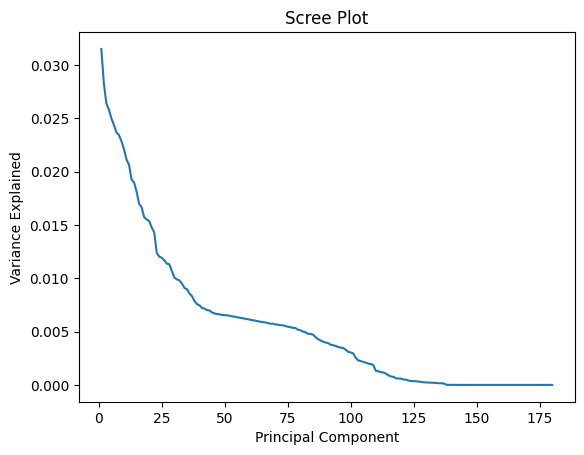

In [29]:
# Scree plot
import matplotlib.pyplot as plt
import numpy as np
PC_values = np.arange(pca.n_components_) + 1 # adding 1 because in python we start from 0
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

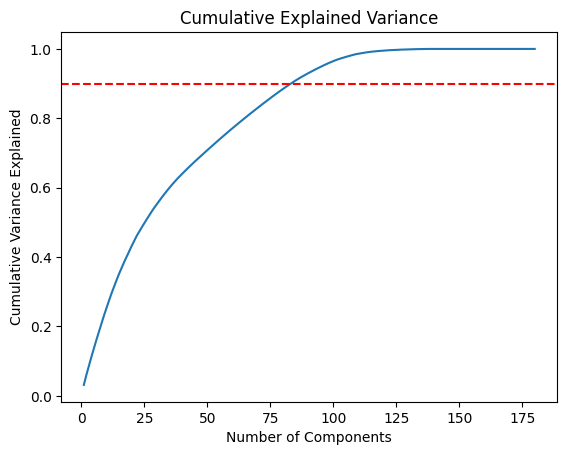

In [30]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()


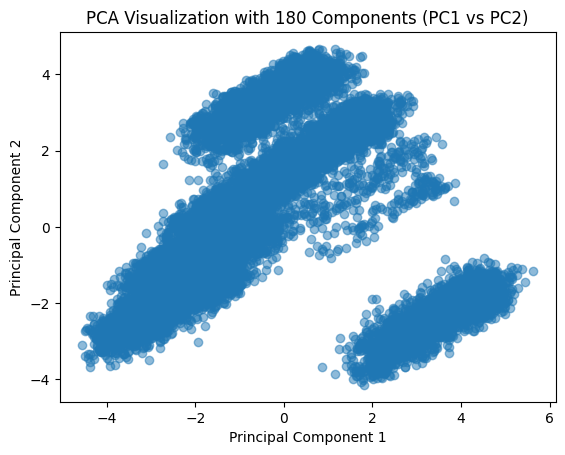

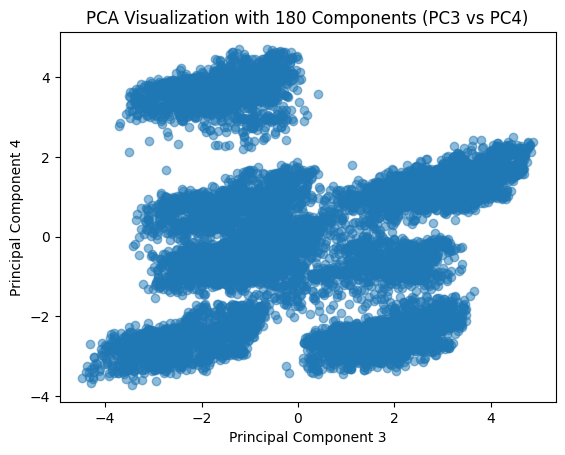

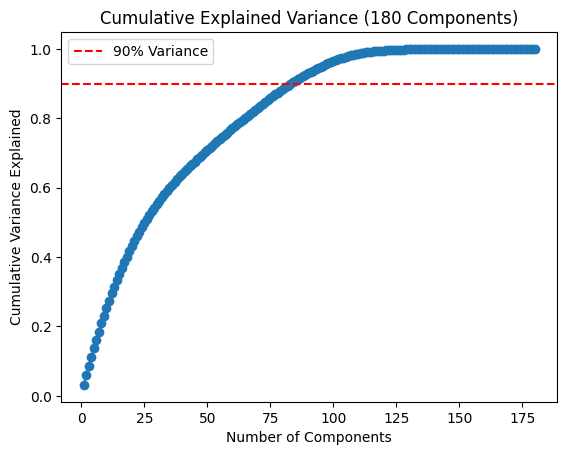

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Initialize PCA with 180 components
pca = PCA(n_components=180)
X_pca = pca.fit_transform(X_std)

# Step 2: Visualize the first two principal components (PC1 vs. PC2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization with 180 Components (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Step 3: Optional - Visualize another pair of components (e.g., PC3 vs. PC4)
plt.scatter(X_pca[:, 2], X_pca[:, 3], alpha=0.5)
plt.title("PCA Visualization with 180 Components (PC3 vs PC4)")
plt.xlabel("Principal Component 3")
plt.ylabel("Principal Component 4")
plt.show()

# Step 4: Analyze cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance (180 Components)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.axhline(y=0.9, color='r', linestyle='--', label="90% Variance")
plt.legend()
plt.show()


In [32]:
pca = PCA().fit(X_std)
explained_variance = pca.explained_variance_ratio_.cumsum()
print(explained_variance)


[0.03152713 0.0598374  0.08624544 0.11209698 0.137105   0.16150915
 0.18520259 0.20864776 0.23151316 0.25362871 0.27478026 0.2954265
 0.3147093  0.33370107 0.35184332 0.3688379  0.38550133 0.40123643
 0.41676325 0.4321447  0.44691795 0.4612483  0.47363991 0.48567723
 0.497616   0.50929541 0.52067894 0.5319961  0.54268797 0.55274862
 0.56265455 0.57245465 0.5819653  0.59106356 0.60004629 0.60861794
 0.61694165 0.62480346 0.63238847 0.6398515  0.64705876 0.65421645
 0.66123648 0.66821771 0.67500505 0.68170985 0.68835975 0.69498515
 0.70154636 0.70809529 0.71462042 0.7211109  0.72754032 0.73394656
 0.74029557 0.74660062 0.75286055 0.75907007 0.76523614 0.77136347
 0.77743422 0.78347889 0.78945566 0.79538823 0.80128626 0.80715169
 0.81295589 0.81870326 0.82444924 0.83012655 0.83578712 0.84139541
 0.84698245 0.85251729 0.85798144 0.86340061 0.86876119 0.87410485
 0.87929186 0.88442283 0.8894278  0.89437746 0.89917988 0.90396068
 0.90869126 0.9131826  0.91748379 0.92165496 0.92571936 0.92969

In [33]:
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components: {optimal_components}")


Optimal number of components: 96


In [34]:
pca = PCA(n_components=optimal_components)
X_reduced = pca.fit_transform(X_std)


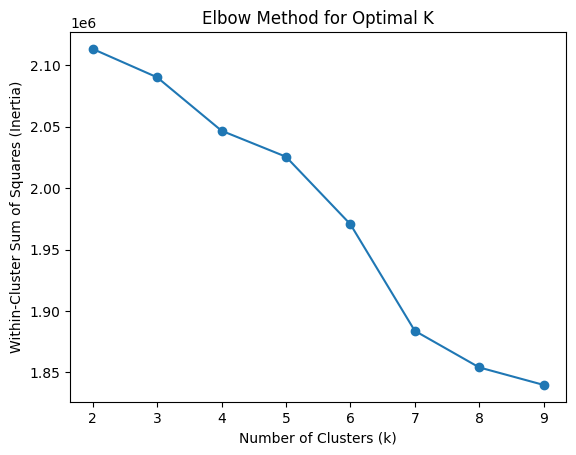

In [35]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# List to store within-cluster sum of squares (inertia)
withinss = []

# Elbow method to determine optimal k
for i in range(2, 10):  # Testing cluster sizes from 2 to 9
    kmeans = KMeans(n_clusters=i, random_state=42)  # Add random_state for reproducibility
    model = kmeans.fit(X_std)  # Use the cleaned data after removing anomalies
    withinss.append(model.inertia_)  # Append inertia (within-cluster sum of squares)

# Plot the elbow graph
plt.plot(range(2, 10), withinss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (Inertia)")
plt.show()


In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Loop through a range of cluster values
for i in range(2, 10):  # Test for k=2 to k=9
    kmeans = KMeans(n_clusters=i, random_state=42)  # Add random_state for reproducibility
    labels = kmeans.fit_predict(X_std)  # Fit and get labels
    score = silhouette_score(X_std, labels)  # Calculate silhouette score
    print(f"Number of Clusters = {i}, Silhouette Score = {score:.4f}")


Number of Clusters = 2, Silhouette Score = 0.0227
Number of Clusters = 3, Silhouette Score = 0.0283
Number of Clusters = 4, Silhouette Score = 0.0366
Number of Clusters = 5, Silhouette Score = 0.0392
Number of Clusters = 6, Silhouette Score = 0.0529
Number of Clusters = 7, Silhouette Score = 0.0817
Number of Clusters = 8, Silhouette Score = 0.0781
Number of Clusters = 9, Silhouette Score = 0.0729


In [37]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(X_std, labels)

# Finding optimal K
### Type your code here ###

for i in range (2,10):
 kmeans = KMeans(n_clusters=i, random_state=42)
 model = kmeans.fit(X_std)
 labels = model.labels_
 print('K=',i,':',calinski_harabasz_score(X_std, labels))


K= 2 : 334.95698005367746
K= 3 : 239.8570650427942
K= 4 : 253.65621347214025
K= 5 : 225.53993585453773
K= 6 : 256.5843502034466
K= 7 : 321.5945553314083
K= 8 : 309.33170248012016
K= 9 : 285.1046198536761


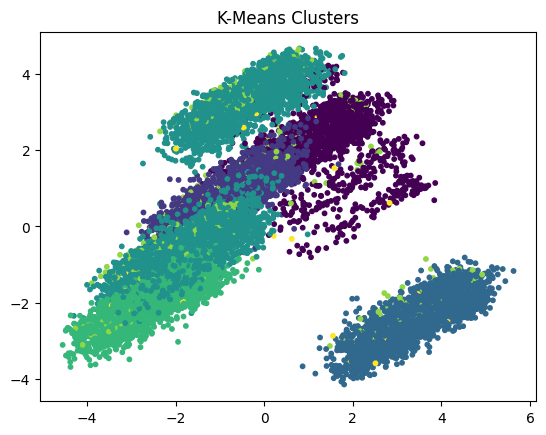

In [38]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust `optimal_k`
labels_kmeans = kmeans.fit_predict(X_reduced)

# Visualize
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_kmeans, cmap='viridis', s=10)
plt.title("K-Means Clusters")
plt.show()


In [39]:
import numpy as np

# Calculate the number of points in each cluster
unique_labels, counts = np.unique(labels_kmeans, return_counts=True)

# Print cluster distribution
print("Cluster Distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")


Cluster Distribution:
Cluster 0: 2037 points
Cluster 1: 1416 points
Cluster 2: 2407 points
Cluster 3: 3930 points
Cluster 4: 1993 points
Cluster 5: 913 points
Cluster 6: 70 points


DBSCAN

As using from eps=0.5 did not give a good result, k-Distance Plot (consulted with the internet sources for this method) has been used to find a starting point. As shown in the graph, 

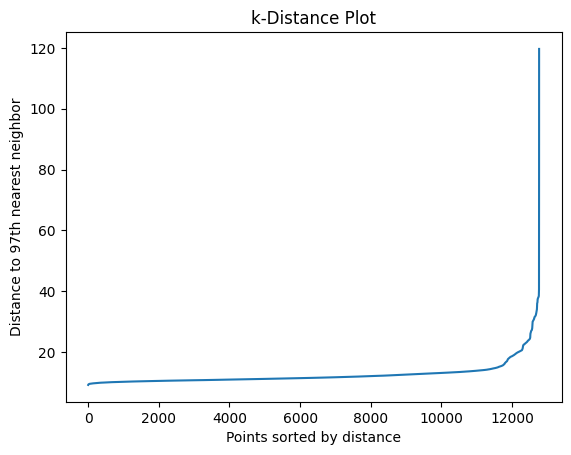

In [40]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Fit NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=97)  # Choose n_neighbors = min_samples
neighbors_fit = neighbors.fit(X_std)
distances, indices = neighbors.kneighbors(X_std)

# Sort distances to find the "elbow"
distances = np.sort(distances[:, -1])  # Sort by distance to the 10th nearest neighbor
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 97th nearest neighbor")
plt.title("k-Distance Plot")
plt.show()


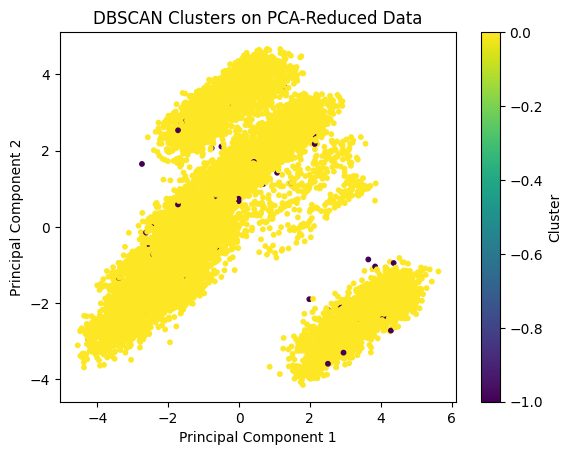

In [41]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=30, min_samples=97)  # Adjust `eps` and `min_samples` using a k-distance plot
labels_dbscan = dbscan.fit_predict(X_reduced)

# Visualize clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title("DBSCAN Clusters on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [42]:
import numpy as np

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
print(f"Cluster Labels: {unique_labels}")
print(f"Counts per Cluster: {dict(zip(unique_labels, counts))}")


Cluster Labels: [-1  0]
Counts per Cluster: {-1: 90, 0: 12676}


In [43]:
for min_samples in [10, 50, 97, 150]:
    dbscan = DBSCAN(eps=30, min_samples=min_samples)
    labels = dbscan.fit_predict(X_reduced)
    print(f"min_samples={min_samples}, clusters={len(set(labels)) - (1 if -1 in labels else 0)}, noise={list(labels).count(-1)}")

min_samples=10, clusters=8, noise=2
min_samples=50, clusters=1, noise=90
min_samples=97, clusters=1, noise=90
min_samples=150, clusters=1, noise=90


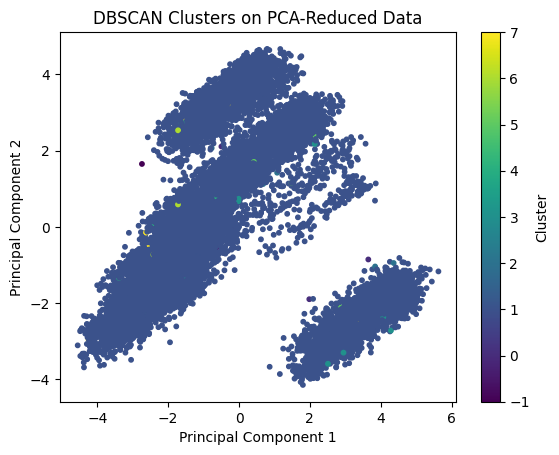

In [44]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=30, min_samples=10)  # Adjust `eps` and `min_samples` using a k-distance plot
labels_dbscan = dbscan.fit_predict(X_reduced)

# Visualize clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title("DBSCAN Clusters on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [45]:
import numpy as np

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
print(f"Cluster Labels: {unique_labels}")
print(f"Counts per Cluster: {dict(zip(unique_labels, counts))}")


Cluster Labels: [-1  0  1  2  3  4  5  6  7]
Counts per Cluster: {-1: 2, 0: 11, 1: 12676, 2: 15, 3: 16, 4: 11, 5: 12, 6: 13, 7: 10}


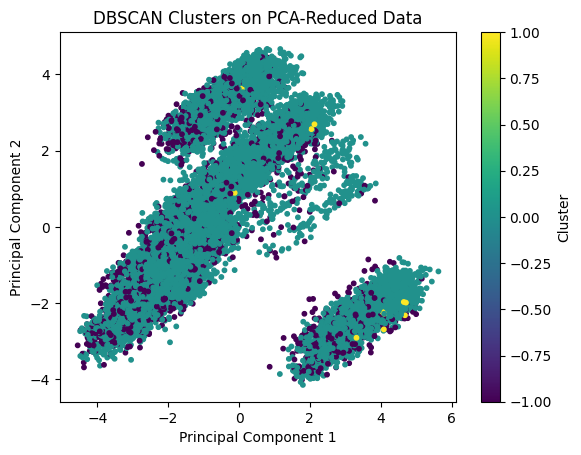

In [46]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=10, min_samples=10)  # Adjust `eps` and `min_samples` using a k-distance plot
labels_dbscan = dbscan.fit_predict(X_reduced)

# Visualize clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title("DBSCAN Clusters on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [47]:
import numpy as np

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
print(f"Cluster Labels: {unique_labels}")
print(f"Counts per Cluster: {dict(zip(unique_labels, counts))}")


Cluster Labels: [-1  0  1]
Counts per Cluster: {-1: 2361, 0: 10394, 1: 11}


As the change in hyperparameters are not leading to an improvement, concluded that DBSCAN might not be suitable model for the dataset. Instead, an attempt to use DBSCAN to define the noises and exclude them from the data to see if it improves K-means clustering result.

In [48]:
import numpy as np

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
print(f"Cluster Labels: {unique_labels}")
print(f"Counts per Cluster: {dict(zip(unique_labels, counts))}")


Cluster Labels: [-1  0  1]
Counts per Cluster: {-1: 2361, 0: 10394, 1: 11}


In [49]:
noise_points = len(labels[labels == -1])
print(f"Number of Noise Points: {noise_points}")


Number of Noise Points: 90


In [50]:
cleaned_data = X_std[labels != -1]
cleaned_labels = labels[labels != -1]


Finding optimal k after reducing noice.

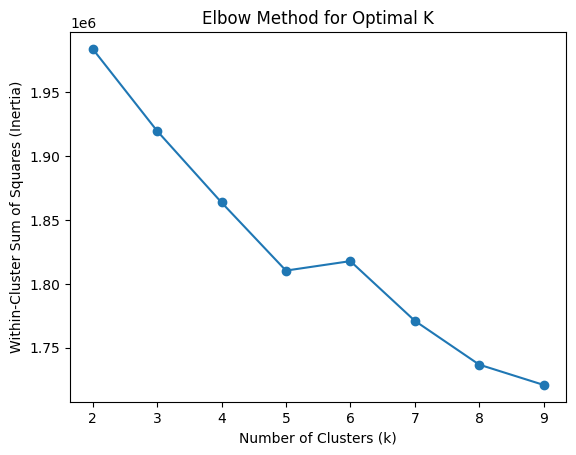

In [51]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# List to store within-cluster sum of squares (inertia)
withinss = []

# Elbow method to determine optimal k
for i in range(2, 10):  # Testing cluster sizes from 2 to 9
    kmeans = KMeans(n_clusters=i, random_state=42)  # Add random_state for reproducibility
    model = kmeans.fit(cleaned_data)  # Use the cleaned data after removing anomalies
    withinss.append(model.inertia_)  # Append inertia (within-cluster sum of squares)

# Plot the elbow graph
plt.plot(range(2, 10), withinss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (Inertia)")
plt.show()


In [52]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Loop through a range of cluster values
for i in range(2, 10):  # Test for k=2 to k=9
    kmeans = KMeans(n_clusters=i, random_state=42)  # Add random_state for reproducibility
    labels = kmeans.fit_predict(cleaned_data)  # Fit and get labels
    score = silhouette_score(cleaned_data, labels)  # Calculate silhouette score
    print(f"Number of Clusters = {i}, Silhouette Score = {score:.4f}")


Number of Clusters = 2, Silhouette Score = 0.0250
Number of Clusters = 3, Silhouette Score = 0.0417
Number of Clusters = 4, Silhouette Score = 0.0573
Number of Clusters = 5, Silhouette Score = 0.0708
Number of Clusters = 6, Silhouette Score = 0.0566
Number of Clusters = 7, Silhouette Score = 0.0672
Number of Clusters = 8, Silhouette Score = 0.0705
Number of Clusters = 9, Silhouette Score = 0.0705


In [53]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(cleaned_data, labels)

# Finding optimal K
### Type your code here ###

for i in range (2,10):
 kmeans = KMeans(n_clusters=i, random_state=42)
 model = kmeans.fit(cleaned_data)
 labels = model.labels_
 print('K=',i,':',calinski_harabasz_score(cleaned_data, labels))


K= 2 : 352.41464661152696
K= 3 : 393.925840055571
K= 4 : 397.3845047597314
K= 5 : 400.08829718524476
K= 6 : 308.407022846998
K= 7 : 319.4084714602752
K= 8 : 314.9388977875581
K= 9 : 292.70301692545576


Conclusion: k=5

In [54]:
kmeans = KMeans(n_clusters=5)
labels_kmeans = kmeans.fit_predict(cleaned_data)


In [55]:
import numpy as np

unique_labels, counts = np.unique(labels_kmeans, return_counts=True)
print("Cluster Distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")


Cluster Distribution:
Cluster 0: 929 points
Cluster 1: 2522 points
Cluster 2: 6025 points
Cluster 3: 1641 points
Cluster 4: 1559 points


In [56]:
# Extracting the original column names from df
column_list = df.columns.tolist()

# Get the cluster centers from the trained KMeans model
cluster_centers = kmeans.cluster_centers_

# Convert the cluster centers back to the original scale
cluster_centers_original = scaler.inverse_transform(cluster_centers)

# Create a DataFrame with the cluster centers for easier interpretation
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=column_list)

# Display the cluster centers in the original scale
print("\nCluster Centers (Original Scale):")
print(cluster_centers_df)



Cluster Centers (Original Scale):
      state  staff_pick  backers_count   usd_pledged  name_len_clean  \
0  0.541442    0.120560      80.989236   6699.887038        4.913886   
1  0.690325    0.174465     115.149881  10643.734880        5.014671   
2  0.500083    0.116349      76.686805   7142.673019        5.086639   
3  0.639854    0.173065     105.859842   9896.726307        4.835466   
4  0.597178    0.136626      96.304041   8750.555667        4.846697   

   blurb_len_clean  staff_pick.1  show_feature_image     video      goal_usd  \
0        14.895587           0.0            0.026911  0.652314  21430.091643   
1        14.163362           0.0            0.033307  0.622918  18657.073084   
2        16.330290           0.0            0.027884  0.669544  41176.370542   
3        13.532602           0.0            0.029250  0.653260  19365.702695   
4        13.588198           0.0            0.028865  0.590763  14998.110547   

   created_at_yr_2011  created_at_yr_2012  created_